In [1]:
import random
import time
import pandas as pd
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

### Load the data

In [2]:
df_news = pd.read_csv('../data/bandits/bandits_exam.csv') 
df_news.head()

,arm,reward
0,1,4.10
1,3,6.04
2,4,3.60
3,2,3.98
4,3,4.72


### Superficial look at the data

In [3]:
df_news.shape

(300000, 2)

In [4]:
# Nan values?
nan_values = df_news.isna().sum()
nan_values

arm       0
reward    0
dtype: int64

## Baseline: explotation only
I'll use the GaussianArm class for all the bandit algorithms implemented

In [5]:
class GaussianArm():
    """
    An arm with a gaussian distribution (bounded)
    """
    def __init__(self, mean, stdev, minv, maxv):
        """
        @param mean: mean of the distribution
        @param stdev: standard deviation of the distribution
        @param minv: minimum possible value
        @param maxv: maximum possible value
        """
        self.mean = mean
        self.stdev = stdev
        self.minv = minv
        self.maxv = maxv

    def pull(self):
        """
        Pull the arm and get a reward
        @return the reward
        """
        reward = min(self.maxv, max(self.minv, round(normal(loc=self.mean, scale=self.stdev),2)))
        return reward
    
    def pull_list(self, T):
        """
        Pull the arm T times
        @return the list of rewards
        """
        rewards = normal(loc=self.mean, scale=self.stdev, size=T)
        rewards = [min(self.maxv, max(self.minv, round(r,2))) for r in rewards]
        return rewards

Modification of the Epsion-Greedy class provided in exercise session

In [6]:
class NaiveStrategy:
    """
    Naive strategy MAB that explores all the arms once and then sticks to the best arm (full exploitation).
    """
    def __init__(self, K):
        """
        @param K: number of arms
        """
        self.K = K
        self.avg_rewards = np.zeros(self.K)  # average reward for each arm
        self.tot_rewards = np.zeros(self.K)  # total reward for each arm
        self.times_pulled = np.zeros(self.K)  # number of times each arm was pulled
        self.initial_exploration_done = False  # flag to check if initial exploration is done
        
    def get_tot_reward(self):
        """
        @return the total reward accumulated
        """
        return sum(self.tot_rewards)
    
    def get_number_pulls(self):
        """
        @return the total number of times an arm has been pulled
        """
        return sum(self.times_pulled)
    
    def __str__(self):
        s = f'=== MAB state ===\n'
        s += f'Naive Strategy: arms={self.K}\n'
        s += f'Trained with {self.get_number_pulls()} actions; Total reward = {self.get_tot_reward()}\n'
        s += f'Avg. reward = {self.avg_rewards}\n'
        s += f'# pulls = {self.times_pulled}\n'
        s += '================='
        return s
        
    def select_arm(self):
        """
        Select the best arm according to the strategy
        @return arm: the index of the selected arm
        """
        if not self.initial_exploration_done:
            for arm in range(self.K):
                if self.times_pulled[arm] == 0:
                    return arm
            self.initial_exploration_done = True
        
        best_arm_idx = np.argmax(self.avg_rewards)
        return best_arm_idx

    def update(self, arm, reward):
        """
        Update the model parameters
        @param arm: arm 
        @param reward : binary value
        """
        self.times_pulled[arm] += 1
        self.tot_rewards[arm] += reward
        self.avg_rewards[arm] = self.tot_rewards[arm] / self.times_pulled[arm]
        
    def reset(self):
        """
        Reset the state of MAB
        """
        self.avg_rewards = np.zeros(self.K)
        self.tot_rewards = np.zeros(self.K)
        self.times_pulled = np.zeros(self.K)
        self.initial_exploration_done = False
        
    def run_simulation(self, arms, T, verbose=False):
        """
        Runs a simulation on the given arms for T timesteps
        @param arms: List of Arms objects
        @param T: length of the simulation
        """
        simulation_cum_rewards = []
        simulation_tot_rewards = 0
        pull_history = []
        if len(arms) != self.K:
            raise Exception(f'number of arms should be K={self.K}')
        for t in range(T):
            arm = self.select_arm()
            reward = arms[arm].pull()
            simulation_tot_rewards += reward
            simulation_cum_rewards.append(simulation_tot_rewards)
            pull_history.append(arm)
            self.update(arm, reward)
            if verbose:
                print(f'ROUND {t} ---')
                print(f'arm={arm}, reward={reward}')
                print(f'avg_rewards = {self.avg_rewards}')
        return (simulation_cum_rewards, pull_history)
        
    def run_replay(self, data, p_arms,  verbose=False):
        """
        Runs a Replay offline evaluation with the given data for p_arms arm pulls
        @param data: a list of (arm,reward) pairs
        @param verbose: for a verbose representation of the replay
        """
        replay_num_matches = 0
        replay_tot_rewards = 0
        replay_cum_rewards = []
        pull_history = []
        for i, action in enumerate(data):
            if replay_num_matches >= p_arms:
                break
            mab_arm = self.select_arm()
            actual_arm, reward = action
            if mab_arm == actual_arm: # change the state of the MAB only if there is a match
                if verbose:
                    print(f'ROUND {replay_num_matches} ({i}) ---')
                    print(f'arm={actual_arm}, mab_arm={mab_arm}, match={mab_arm == actual_arm}, reward={reward}')
                    print(f'avg_rewards = {self.avg_rewards}')
                replay_num_matches += 1
                replay_tot_rewards += reward
                replay_cum_rewards.append(replay_tot_rewards)
                pull_history.append(mab_arm)
                self.update(mab_arm, reward)
        return (replay_cum_rewards, pull_history)
def visualize_simulation(cum_rewards, pull_history, savefile=None):
    """
    Utility function to draw a visual representation of the simulation
    @param cum_rewards: list of cumulative rewards in time
    @param pull_history: list of arm indices pulled over time
    """
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))  
    ax1, ax2 = axs

    def format_with_dots(x, pos):
        return f'{int(x):,}'.replace(',', '.')

    # Plot cumulative rewards
    ax1.plot(range(0, len(cum_rewards)), cum_rewards)
    ax1.set_ylabel('Cumulative Reward', fontsize=18)
    ax1.set_xlabel('News rated', fontsize=18)
    ax1.xaxis.set_major_formatter(ticker.FuncFormatter(format_with_dots))
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_with_dots))
    # Plot pull history
    ax2.scatter(range(0, len(pull_history)), pull_history, s=4, alpha=0.8)
    ax2.set_ylabel('News article type', fontsize=18)
    ax2.set_xlabel('News read', fontsize=18)
    ax2.xaxis.set_major_formatter(ticker.FuncFormatter(format_with_dots))
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_with_dots))
    # Set tick parameters
    ax1.tick_params(labelsize=18)
    ax2.tick_params(labelsize=18)
    # Adjust layout for better spacing
    plt.tight_layout()
    if savefile:
        plt.savefig(savefile, dpi=400)

    plt.show()

#### Run simulation
Now we need to compute the mean and standard deviation of each arm to run the simulation:

In [7]:
grouped_stats = df_news.groupby('arm')['reward'].agg(['mean', 'std']).reset_index()
grouped_stats

,arm,mean,std
0,0,4.000216,2.115624
1,1,4.782196,1.083183
2,2,4.891306,0.893014
3,3,4.984554,0.986532
4,4,4.603683,1.079297
5,5,4.174860,1.459153


In [8]:
#create example arms
min_rating = 0 
max_rating = 7 
arms = [ GaussianArm(grouped_stats.loc[0].values[1], grouped_stats.loc[0].values[2], min_rating, max_rating),
         GaussianArm(grouped_stats.loc[1].values[1], grouped_stats.loc[1].values[2], min_rating, max_rating),
         GaussianArm(grouped_stats.loc[2].values[1], grouped_stats.loc[2].values[2], min_rating, max_rating),
         GaussianArm(grouped_stats.loc[3].values[1], grouped_stats.loc[3].values[2], min_rating, max_rating),
         GaussianArm(grouped_stats.loc[4].values[1], grouped_stats.loc[4].values[2], min_rating, max_rating),
         GaussianArm(grouped_stats.loc[5].values[1], grouped_stats.loc[5].values[2], min_rating, max_rating)]

#instantiate MAB
K = len(arms)
naive_mab = NaiveStrategy(K)

Since we are gonna evaluate on the cumulative reward up to 10K news, then I'll set T to 10K as well to avoid computation overload.

=== MAB state ===
Naive Strategy: arms=6
Trained with 10000.0 actions; Total reward = 49672.979999999756
Avg. reward = [4.79833333 4.14       4.71769231 4.96797854 4.826      4.47      ]
# pulls = [6.000e+00 1.000e+00 1.300e+01 9.973e+03 5.000e+00 2.000e+00]


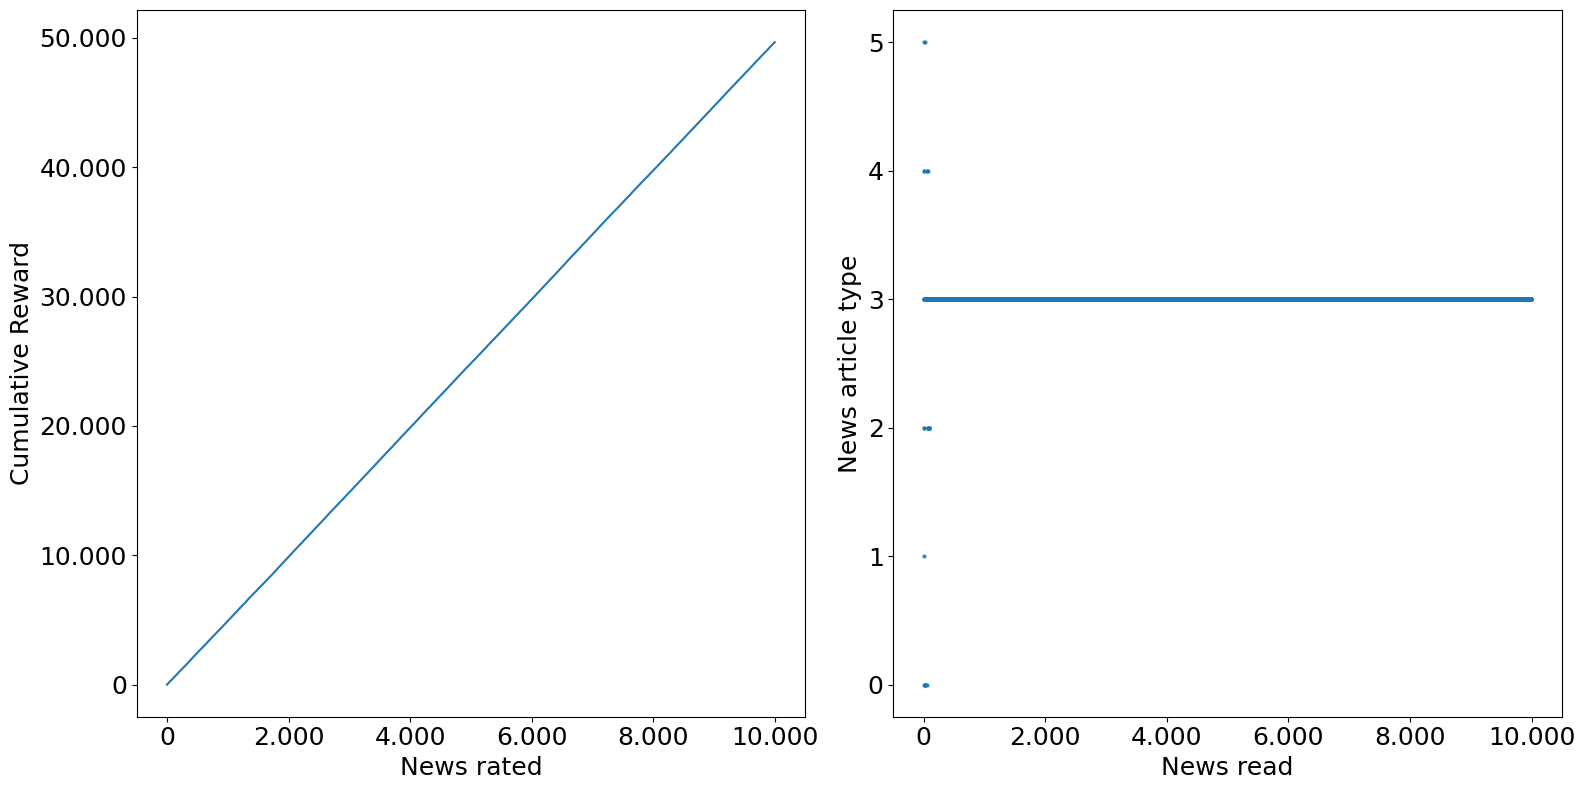

In [9]:
#run simulation on given arms
T = 10000
cum_rewards_naive, pull_history_naive = naive_mab.run_simulation(arms, T, verbose=False)
print(naive_mab)
visualize_simulation(cum_rewards_naive, pull_history_naive, 'Naive_bandit_simulation.png')

#### Run Replay
Store the news and ratings as a list of tuples in the format (arm, reward) to run the replay.

In [10]:
arms_data = list(df_news.itertuples(index=False, name=None))

In [11]:
max_arm_pull = 10000

=== MAB state ===
Naive Strategy: arms=6
Trained with 10000.0 actions; Total reward = 49772.74000000012
Avg. reward = [3.49       4.73210526 4.77639535 4.98360016 2.63       4.395     ]
# pulls = [1.000e+00 1.900e+01 2.580e+02 9.719e+03 1.000e+00 2.000e+00]


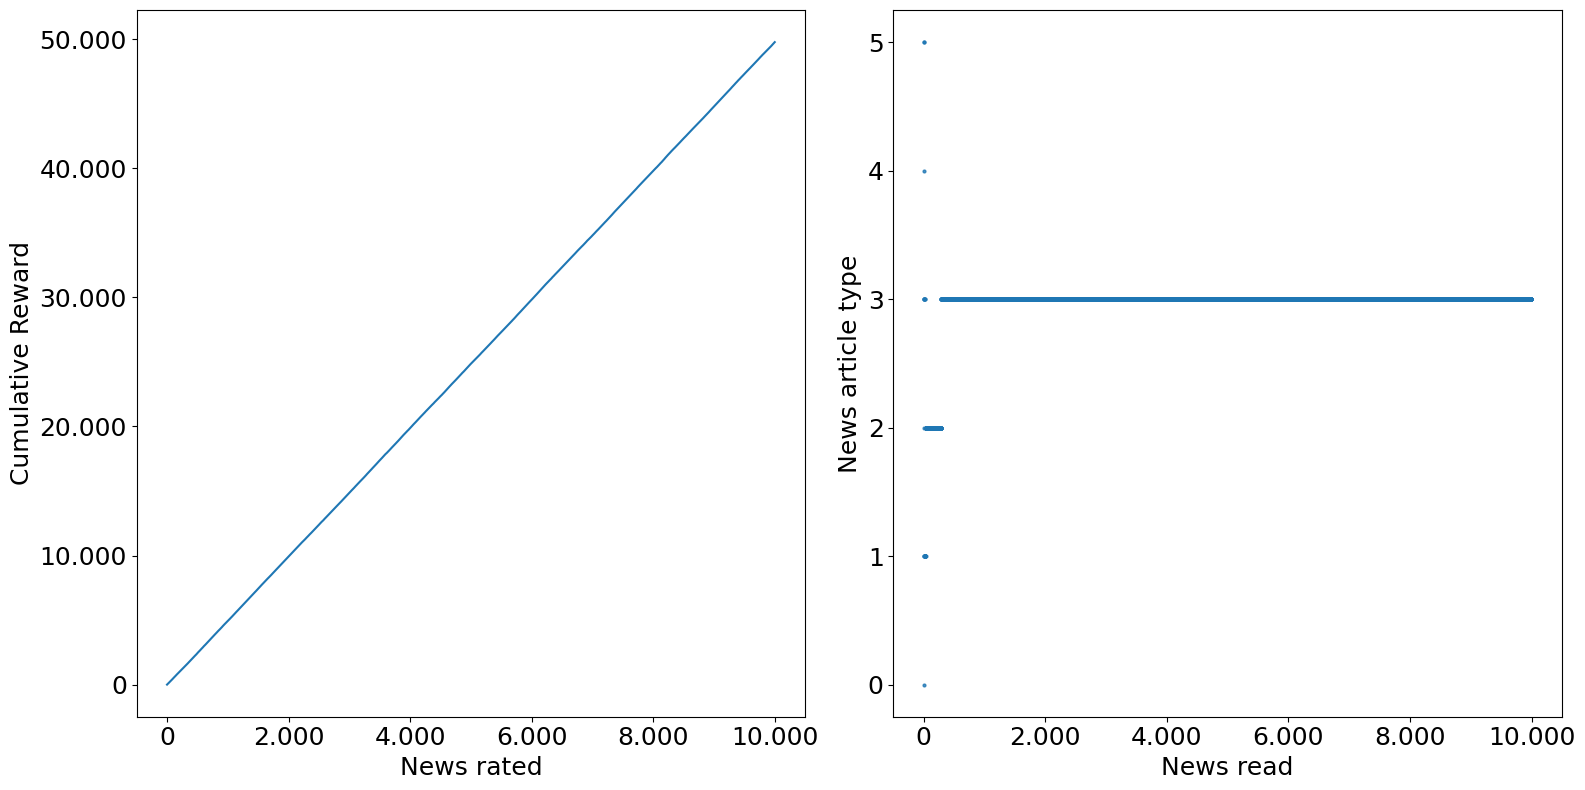

In [12]:
naive_mab = NaiveStrategy(K)
#run Replay on given data
cum_rewards_naive_replay, pull_history_naive_replay = naive_mab.run_replay(arms_data, max_arm_pull, verbose=False)
print(naive_mab)

visualize_simulation(cum_rewards_naive_replay, pull_history_naive_replay)

## $\epsilon$ - Greedy Strategy bandit algorithm

Using the EpsilonGreedy class provided in lecture 4 of Rec Sys as well as the class GaussianArm.

In [14]:
class EpsilonGreedy:
    """
    Epsilon greedy MAB
    """
    def __init__(self, epsilon, K):
        """
        @param epsilon : the epsilon-greedy exploration parameter
        @param K: number of arms
        """
        if epsilon < 0 or epsilon > 1:
            raise Exception ('Epsilon should be in [0,1]')
        self.epsilon = epsilon
        self.K = K
        self.avg_rewards = np.zeros(self.K)  # average reward for each arm
        self.tot_rewards = np.zeros(self.K)  # total reward for each arm
        self.times_pulled = np.zeros(self.K)  # number of times each arm was pulled
        
    def get_tot_reward(self):
        """
        @return the total reward accumulated
        """
        return sum(self.tot_rewards)
    
    def get_number_pulls(self):
        """
        @return the total number of times an arm has been pulled
        """
        return sum(self.times_pulled)
    
    def __str__(self):
        s = f'=== MAB state ===\n'
        s += f'Epsilon Greedy: epsilon={self.epsilon}, arms={self.K}\n'
        s += f'Trained with {self.get_number_pulls()} actions; Total reward = {self.get_tot_reward()}\n'
        s += f'Avg. reward = {self.avg_rewards}\n'
        s += f'# pulls = {self.times_pulled}\n'
        s += '================='
        return s
        
    def select_arm(self):
        """
        Select the best arm according to the strategy
        @return arm: the index of the selected arm
        @return explore: binary value encoding whether the MAB decided to explore
        """
        p = np.random.rand()
        if p > self.epsilon:
            best_arm_idx = np.argmax(self.avg_rewards)
            return (best_arm_idx, 0)
        else:
            return (np.random.choice(range(0,self.K)), 1)

    def update(self, arm, reward):
        """
        Update the model parameters
        @param arm: arm 
        @param reward : binary value
        """
        self.times_pulled[arm] += 1
        self.tot_rewards[arm] += reward
        self.avg_rewards[arm] = self.tot_rewards[arm] / self.times_pulled[arm]
        
    def reset(self):
        """
        Reset the state of MAB
        """
        self.avg_rewards = np.zeros(self.K)
        self.tot_rewards = np.zeros(self.K)
        self.times_pulled = np.zeros(self.K)
        self.pull_history = []
        
    def run_simulation(self, arms, T, verbose=False):
        """
        Runs a simulation on the given arms for T timesteps
        @param arms: List of Arms objects
        @param T: length of the simulation
        """
        simulation_cum_rewards = []
        simulation_tot_rewards = 0
        pull_history = []
        if len(arms) != K:
            raise Exception(f'number of arms shuould be K={self.K}')
        for t in range(0, T):
            arm, has_explored = self.select_arm()
            reward = arms[arm].pull()
            simulation_tot_rewards += reward
            simulation_cum_rewards.append(simulation_tot_rewards)
            pull_history.append(arm)
            self.update(arm, reward)
            if verbose:
                print(f'ROUND {t} ---')
                print(f'arm={arm}, has_explored={has_explored}, reward={reward}')
                print(f'avg_rewards = {self.avg_rewards}')
        return (simulation_cum_rewards, pull_history)
        
    def run_replay(self, data, p_arm, verbose=False):
        """
        Runs a Replay offline evaluation with the given data
        @param data: a list of (arm,reward) pairs
        @param verbose: for a verbose representation of the replay
        """
        replay_num_matches = 0
        replay_tot_rewards = 0
        replay_cum_rewards = []
        pull_history = []
        for i, action in enumerate(data):
            if replay_num_matches >= p_arm:
                break
            mab_arm, has_explored = self.select_arm()
            actual_arm, reward = action
            if mab_arm == actual_arm: #change the state of the MAB only if there is a match
                if verbose:
                    print(f'ROUND {replay_num_matches} ({i}) ---')
                    print(f'arm={actual_arm}, mab_arm={mab_arm}, match={mab_arm == actual_arm}, has_explored={has_explored}, reward={reward}')
                    print(f'avg_rewards = {self.avg_rewards}')
                replay_num_matches += 1
                replay_tot_rewards += reward
                replay_cum_rewards.append(replay_tot_rewards)
                pull_history.append(mab_arm)
                mab.update(mab_arm, reward)
        return (replay_cum_rewards, pull_history)
    

#### Run simulation

In [16]:
#create example arms
min_rating = 0 
max_rating = 7 
arms = [ GaussianArm(grouped_stats.loc[0].values[1], grouped_stats.loc[0].values[2], min_rating, max_rating),
         GaussianArm(grouped_stats.loc[1].values[1], grouped_stats.loc[1].values[2], min_rating, max_rating),
         GaussianArm(grouped_stats.loc[2].values[1], grouped_stats.loc[2].values[2], min_rating, max_rating),
         GaussianArm(grouped_stats.loc[3].values[1], grouped_stats.loc[3].values[2], min_rating, max_rating),
         GaussianArm(grouped_stats.loc[4].values[1], grouped_stats.loc[4].values[2], min_rating, max_rating),
         GaussianArm(grouped_stats.loc[5].values[1], grouped_stats.loc[5].values[2], min_rating, max_rating)]

#instantiate MAB
K = len(arms)
alpha = 0.17
mab = EpsilonGreedy(alpha, K)

=== MAB state ===
Epsilon Greedy: epsilon=0.17, arms=6
Trained with 10000.0 actions; Total reward = 49009.950000000084
Avg. reward = [4.06982517 4.83971831 4.81830258 4.96925126 4.62909968 4.12658537]
# pulls = [ 286.  284.  271. 8561.  311.  287.]


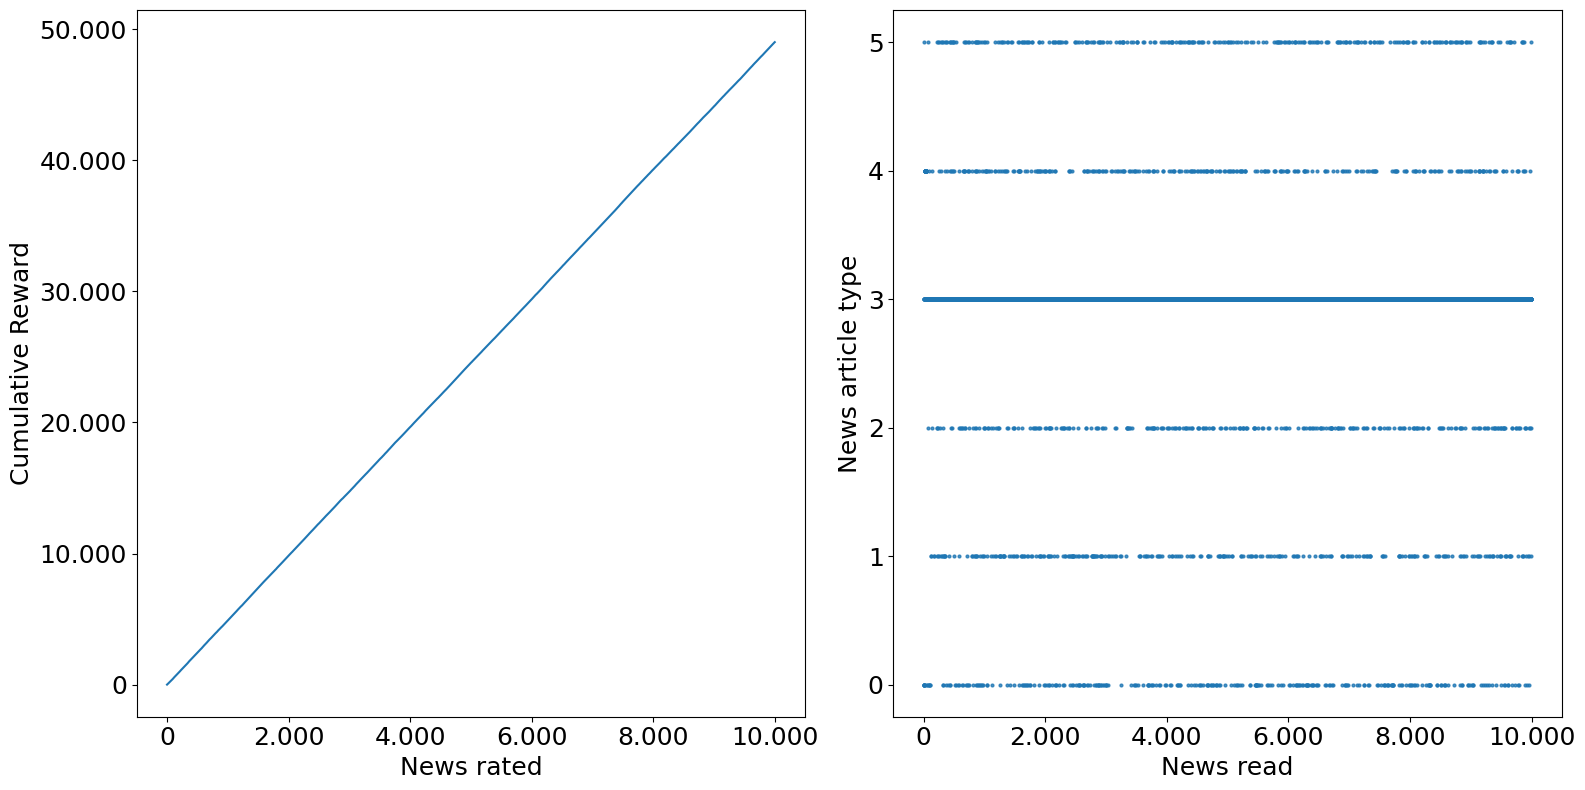

In [17]:
#run simulation on given arms
T = 10000
cum_rewards_epsilon, pull_history_epsilon = mab.run_simulation(arms, T, verbose=False)
print(mab)
visualize_simulation(cum_rewards_epsilon, pull_history_epsilon, 'Epsilon_Greedy_bandit_simulation.png')

#### Run the replay

=== MAB state ===
Epsilon Greedy: epsilon=0.17, arms=6
Trained with 10000.0 actions; Total reward = 49168.55000000011
Avg. reward = [4.0116     4.85878698 4.90431304 4.9870807  4.64529605 4.133     ]
# pulls = [ 275.  338.  575. 8228.  304.  280.]


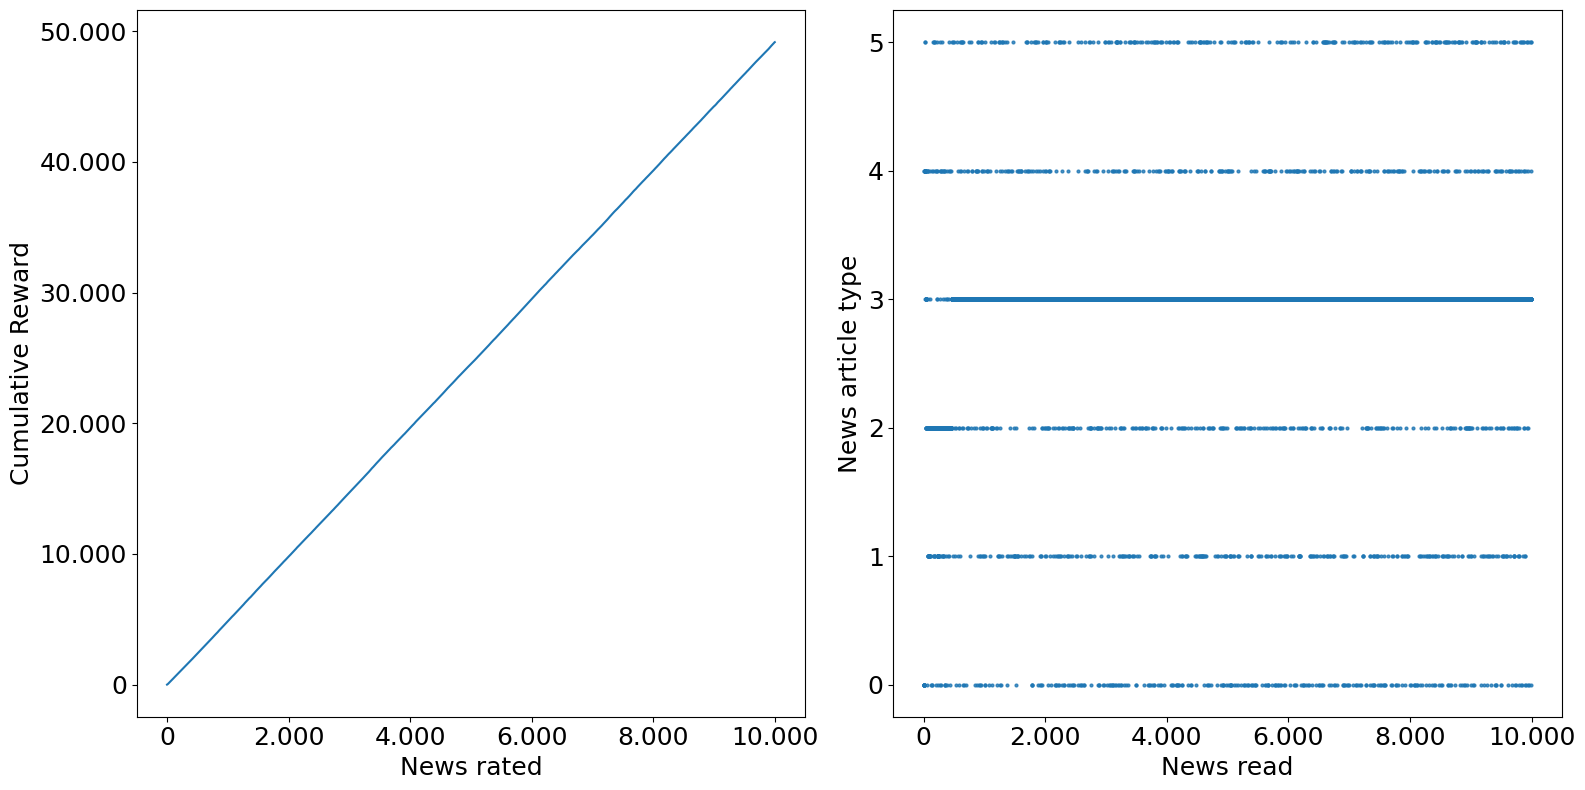

In [18]:
mab = EpsilonGreedy(alpha, K)
#run Replay on given data
cum_rewards_epsilon_replay, pull_history_epsilon_replay = mab.run_replay(arms_data, max_arm_pull, verbose=False)
print(mab)

visualize_simulation(cum_rewards_epsilon_replay, pull_history_epsilon_replay)

## UCB bandit algorithm

In [19]:
class UCB:
    """
    UCB MAB
    """
    def __init__(self, K):
        """
        @param K: number of arms
        """
        self.K = K
        self.avg_rewards = np.zeros(self.K)  # average reward for each arm
        self.tot_rewards = np.zeros(self.K)  # total reward for each arm
        self.times_pulled = np.zeros(self.K)  # number of times each arm was pulled
        self.t = 0  # total number of rounds
        
    def get_tot_reward(self):
        """
        @return the total reward accumulated
        """
        return sum(self.tot_rewards)
    
    def get_number_pulls(self):
        """
        @return the total number of times an arm has been pulled
        """
        return sum(self.times_pulled)
    
    def __str__(self):
        s = f'=== MAB state ===\n'
        s += f'UCB: arms={self.K}\n'
        s += f'Trained with {self.get_number_pulls()} actions; Total reward = {self.get_tot_reward()}\n'
        s += f'Avg. reward = {self.avg_rewards}\n'
        s += f'# pulls = {self.times_pulled}\n'
        s += '================='
        return s
        
    def select_arm(self):
        """
        Select the best arm according to the UCB strategy
        @return arm: the index of the selected arm
        """
        self.t += 1
        
        # If any arm hasn't been pulled yet, select it
        for arm in range(self.K):
            if self.times_pulled[arm] == 0:
                return arm
        
        ucb_values = self.avg_rewards + np.sqrt(2 * np.log(self.t) / self.times_pulled)
        best_arm_idx = np.argmax(ucb_values)
        return best_arm_idx

    def update(self, arm, reward):
        """
        Update the model parameters
        @param arm: arm 
        @param reward : binary value
        """
        self.times_pulled[arm] += 1
        self.tot_rewards[arm] += reward
        self.avg_rewards[arm] = self.tot_rewards[arm] / self.times_pulled[arm]
        
    def reset(self):
        """
        Reset the state of MAB
        """
        self.avg_rewards = np.zeros(self.K)
        self.tot_rewards = np.zeros(self.K)
        self.times_pulled = np.zeros(self.K)
        self.t = 0
        
    def run_simulation(self, arms, T, verbose=False):
        """
        Runs a simulation on the given arms for T timesteps
        @param arms: List of Arms objects
        @param T: length of the simulation
        """
        simulation_cum_rewards = []
        simulation_tot_rewards = 0
        pull_history = []
        if len(arms) != self.K:
            raise Exception(f'number of arms should be K={self.K}')
        for t in range(T):
            arm = self.select_arm()
            reward = arms[arm].pull()
            simulation_tot_rewards += reward
            simulation_cum_rewards.append(simulation_tot_rewards)
            pull_history.append(arm)
            self.update(arm, reward)
            if verbose:
                print(f'ROUND {t} ---')
                print(f'arm={arm}, reward={reward}')
                print(f'avg_rewards = {self.avg_rewards}')
                print(f'# pulls = {self.times_pulled}')
        return (simulation_cum_rewards, pull_history)
        
    def run_replay(self, data, p_arm, verbose=False):
        """
        Runs a Replay offline evaluation with the given data
        @param data: a list of (arm,reward) pairs
        @param verbose: for a verbose representation of the replay
        """
        replay_num_matches = 0
        replay_tot_rewards = 0
        replay_cum_rewards = []
        pull_history = []
        for i, action in enumerate(data):
            if replay_num_matches >= p_arm:
                break
            mab_arm = self.select_arm()
            actual_arm, reward = action
            if mab_arm == actual_arm: # change the state of the MAB only if there is a match
                if verbose:
                    print(f'ROUND {replay_num_matches} ({i}) ---')
                    print(f'arm={actual_arm}, mab_arm={mab_arm}, match={mab_arm == actual_arm}, reward={reward}')
                    print(f'avg_rewards = {self.avg_rewards}')
                replay_num_matches += 1
                replay_tot_rewards += reward
                replay_cum_rewards.append(replay_tot_rewards)
                pull_history.append(mab_arm)
                self.update(mab_arm, reward)
        return (replay_cum_rewards, pull_history)

In [20]:
#create example arms
min_rating = 0 
max_rating = 7 
arms = [ GaussianArm(grouped_stats.loc[0].values[1], grouped_stats.loc[0].values[2], min_rating, max_rating),
         GaussianArm(grouped_stats.loc[1].values[1], grouped_stats.loc[1].values[2], min_rating, max_rating),
         GaussianArm(grouped_stats.loc[2].values[1], grouped_stats.loc[2].values[2], min_rating, max_rating),
         GaussianArm(grouped_stats.loc[3].values[1], grouped_stats.loc[3].values[2], min_rating, max_rating),
         GaussianArm(grouped_stats.loc[4].values[1], grouped_stats.loc[4].values[2], min_rating, max_rating),
         GaussianArm(grouped_stats.loc[5].values[1], grouped_stats.loc[5].values[2], min_rating, max_rating)]

#instantiate MAB
K = len(arms)
ucb_mab = UCB(K)

=== MAB state ===
UCB: arms=6
Trained with 10000.0 actions; Total reward = 49465.720000000074
Avg. reward = [3.90333333 4.72378995 4.90595368 4.97106797 4.71660099 4.18814815]
# pulls = [  21.  219. 1468. 8062.  203.   27.]


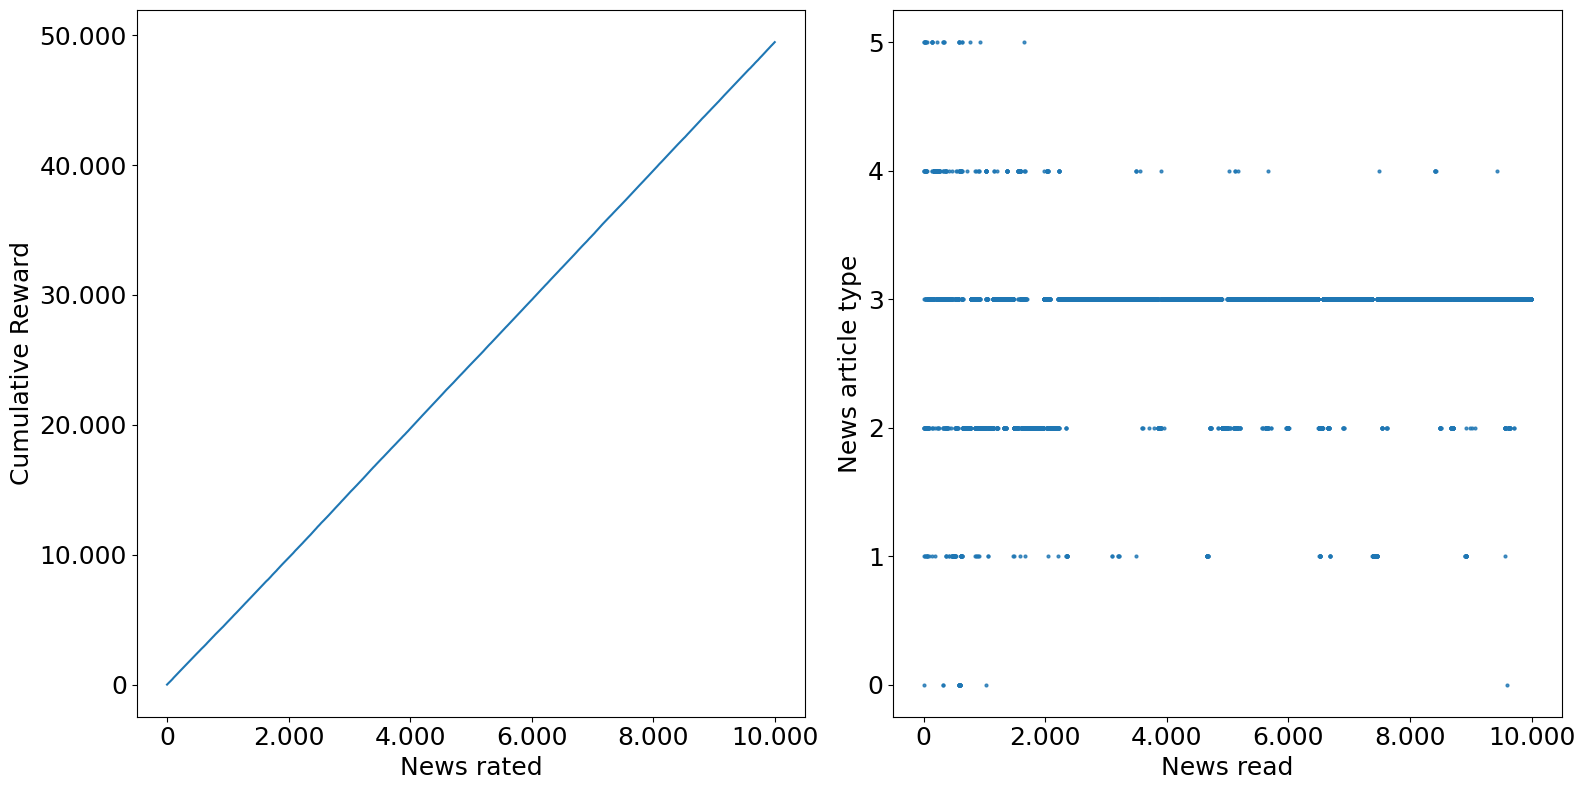

In [21]:
#run simulation on given arms
T = 10000
cum_rewards_ucb, pull_history_ucb = ucb_mab.run_simulation(arms, T, verbose=False)
print(ucb_mab)
visualize_simulation(cum_rewards_ucb, pull_history_ucb, 'UCB_bandit_simulation.png')

=== MAB state ===
UCB: arms=6
Trained with 10000.0 actions; Total reward = 49556.7700000002
Avg. reward = [2.6625     4.83215686 4.86311914 4.97986709 4.52032609 3.91263158]
# pulls = [4.000e+00 5.610e+02 7.470e+02 8.577e+03 9.200e+01 1.900e+01]


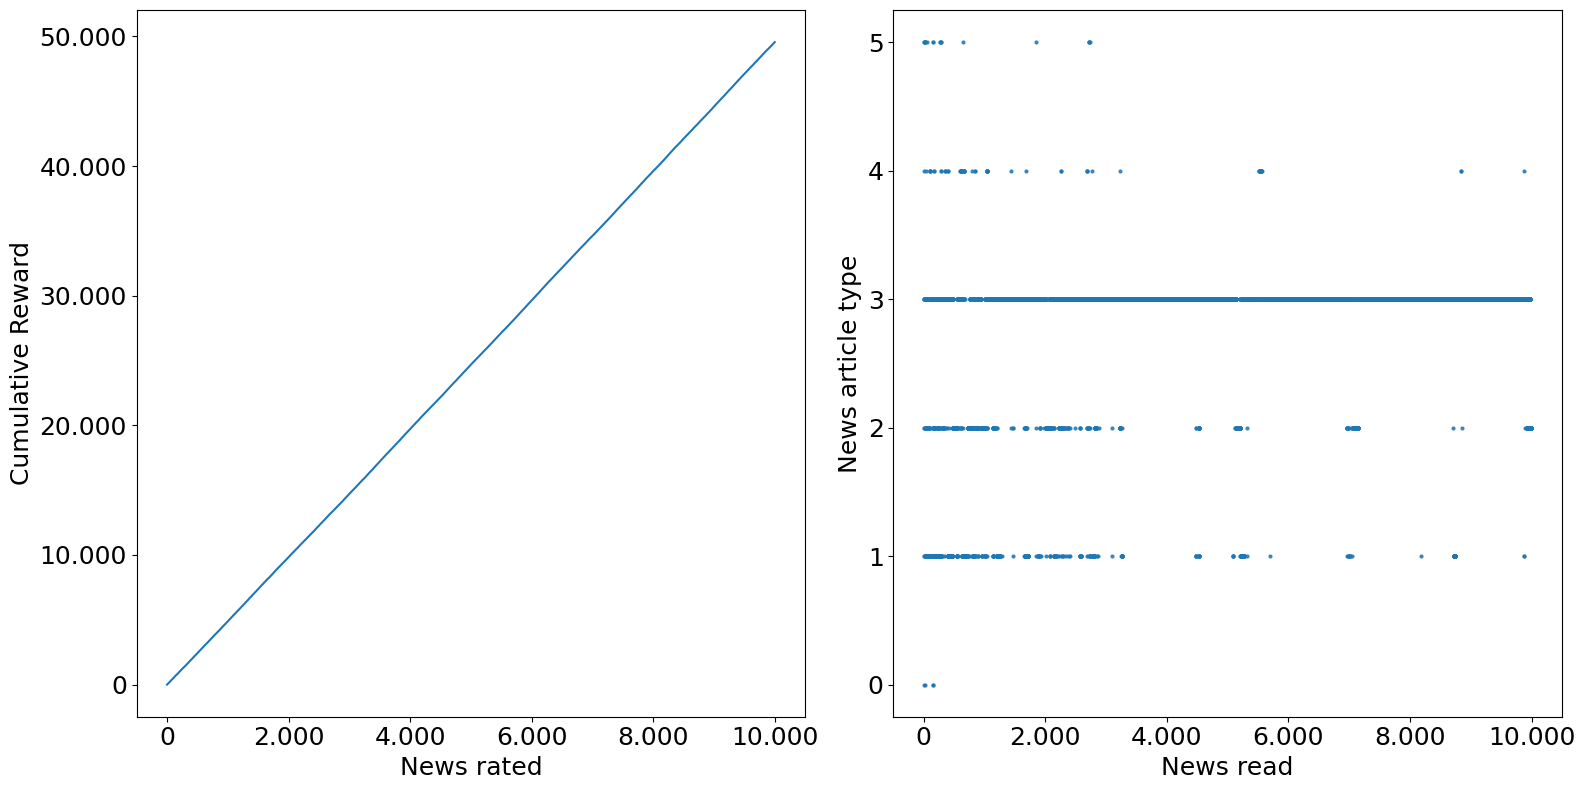

In [22]:
ucb_mab = UCB(K)
#run Replay on given data
cum_rewards_ucb_replay, pull_history_ucb_replay = ucb_mab.run_replay(arms_data, max_arm_pull, verbose=False)
print(ucb_mab)

visualize_simulation(cum_rewards_ucb_replay, pull_history_ucb_replay)

## Final results:

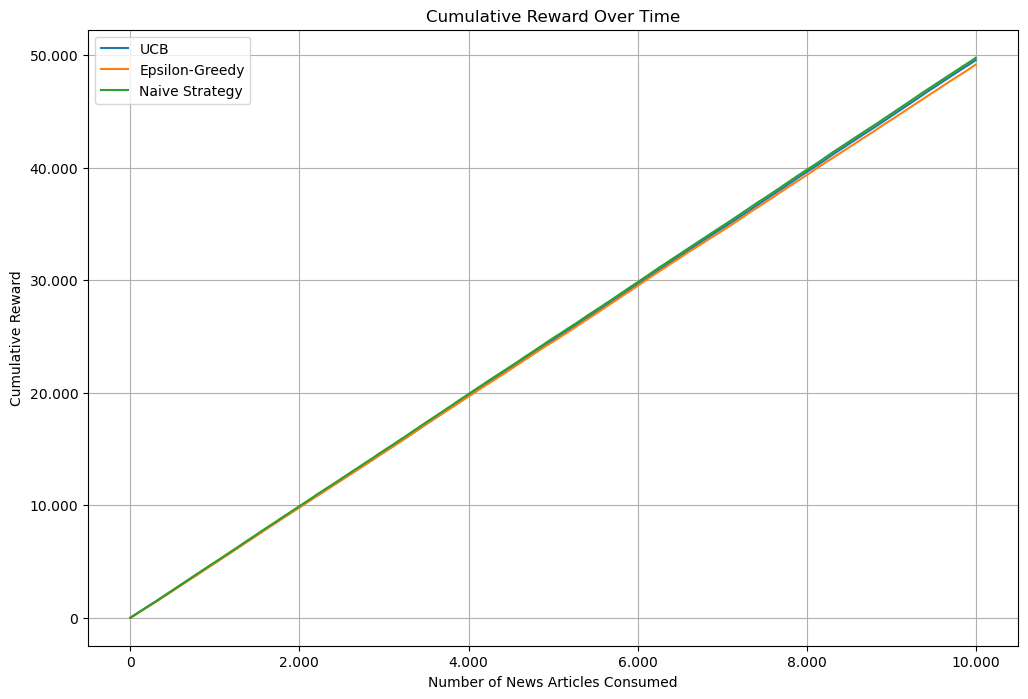

In [23]:
def plot_results(cum_rewards, labels):
    plt.figure(figsize=(12, 8))
    for rewards, label in zip(cum_rewards, labels):
        plt.plot(range(len(rewards)), rewards, label=label)
    
    def format_with_dots(x, pos):
        return f'{int(x):,}'.replace(',', '.')
    
    ax = plt.gca()
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_with_dots))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_with_dots))
    
    plt.xlabel('Number of News Articles Consumed')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the results
plot_results([cum_rewards_ucb_replay, cum_rewards_epsilon_replay, cum_rewards_naive_replay], 
             ['UCB', 'Epsilon-Greedy', 'Naive Strategy'])

Comments:

- Expected:
    - UCB1 performs really well, capturing the trade-off between exploration and exploitation as expected.
    - Epsilon Greedy performance is tied to the epsilon chosen and can be quite sensitive to small changes in epsilon. Small values of epsilon get a higher reward. See below performance with different epsilon values.
- Unexpected:
    - Naives Baseline performs really well in the news data provided, and it seems to identify the best arm to exploit really quickly.

#### Epsilon simulation scenario

=== MAB state ===
Epsilon Greedy: epsilon=0.01, arms=6
Trained with 10000.0 actions; Total reward = 49321.14999999997
Avg. reward = [4.10824176 4.42857143 4.87682132 4.97809639 4.87727273 4.795625  ]
# pulls = [  91.   14. 3621. 6225.   33.   16.]
=== MAB state ===
Epsilon Greedy: epsilon=0.5, arms=6
Trained with 10000.0 actions; Total reward = 47638.709999999985
Avg. reward = [3.98147343 4.78824719 4.87746445 4.9594337  4.67486175 4.1443562 ]
# pulls = [ 828.  890.  844. 5739.  868.  831.]
=== MAB state ===
Epsilon Greedy: epsilon=0.99, arms=6
Trained with 10000.0 actions; Total reward = 45394.47999999998
Avg. reward = [3.94769547 4.76870257 4.84607077 4.98482955 4.57148632 4.11364897]
# pulls = [1701. 1634. 1639. 1760. 1608. 1658.]


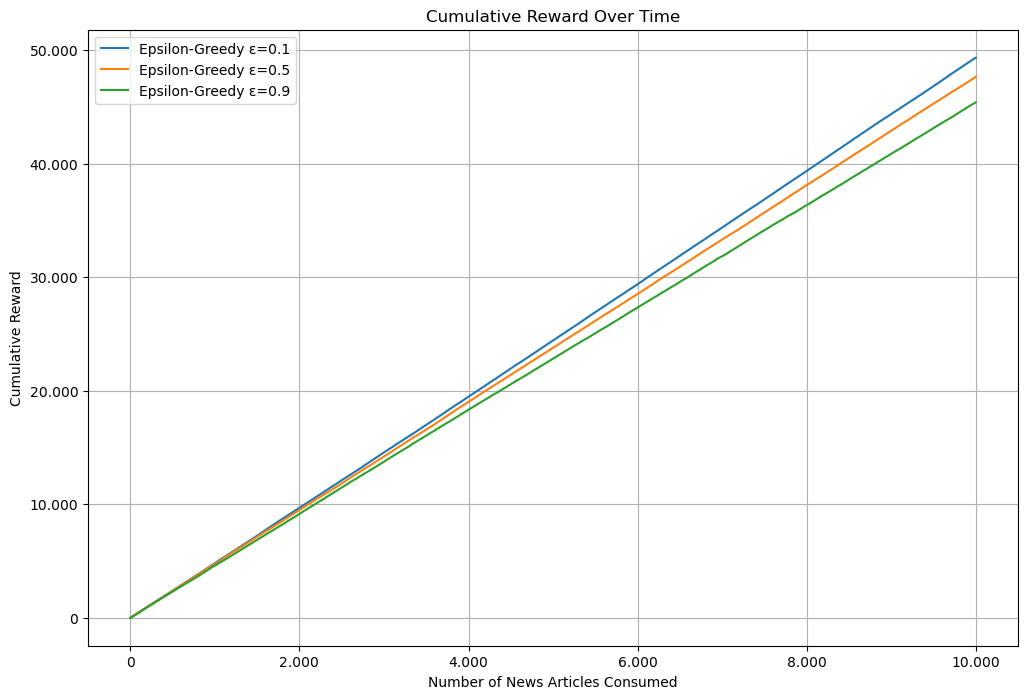

In [32]:
# Initialize bandits with different epsilon values
eg_bandit_01 = EpsilonGreedy(epsilon=0.01, K=K)
eg_bandit_05 = EpsilonGreedy(epsilon=0.5, K=K)
eg_bandit_09 = EpsilonGreedy(epsilon=0.99, K=K)

# Run simulations
cum_rewards_eg_01, pull_eg_bandit_01 = eg_bandit_01.run_simulation(arms, T, verbose=False)
print(eg_bandit_01)
cum_rewards_eg_05, pull_eg_bandit_05 = eg_bandit_05.run_simulation(arms, T,verbose=False)
print(eg_bandit_05)
cum_rewards_eg_09, pull_eg_bandit_05 =  eg_bandit_09.run_simulation(arms, T, verbose=False) 
print(eg_bandit_09)
# Plot the results
plot_results([cum_rewards_eg_01, cum_rewards_eg_05, cum_rewards_eg_09], 
             ['Epsilon-Greedy ε=0.1', 'Epsilon-Greedy ε=0.5', 'Epsilon-Greedy ε=0.9'])

=== MAB state ===
Epsilon Greedy: epsilon=0.01, arms=6
Trained with 10000.0 actions; Total reward = 49321.14999999997
Avg. reward = [4.10824176 4.42857143 4.87682132 4.97809639 4.87727273 4.795625  ]
# pulls = [  91.   14. 3621. 6225.   33.   16.]
=== MAB state ===
Epsilon Greedy: epsilon=0.5, arms=6
Trained with 10000.0 actions; Total reward = 47638.709999999985
Avg. reward = [3.98147343 4.78824719 4.87746445 4.9594337  4.67486175 4.1443562 ]
# pulls = [ 828.  890.  844. 5739.  868.  831.]
=== MAB state ===
Epsilon Greedy: epsilon=0.99, arms=6
Trained with 10000.0 actions; Total reward = 45394.47999999998
Avg. reward = [3.94769547 4.76870257 4.84607077 4.98482955 4.57148632 4.11364897]
# pulls = [1701. 1634. 1639. 1760. 1608. 1658.]


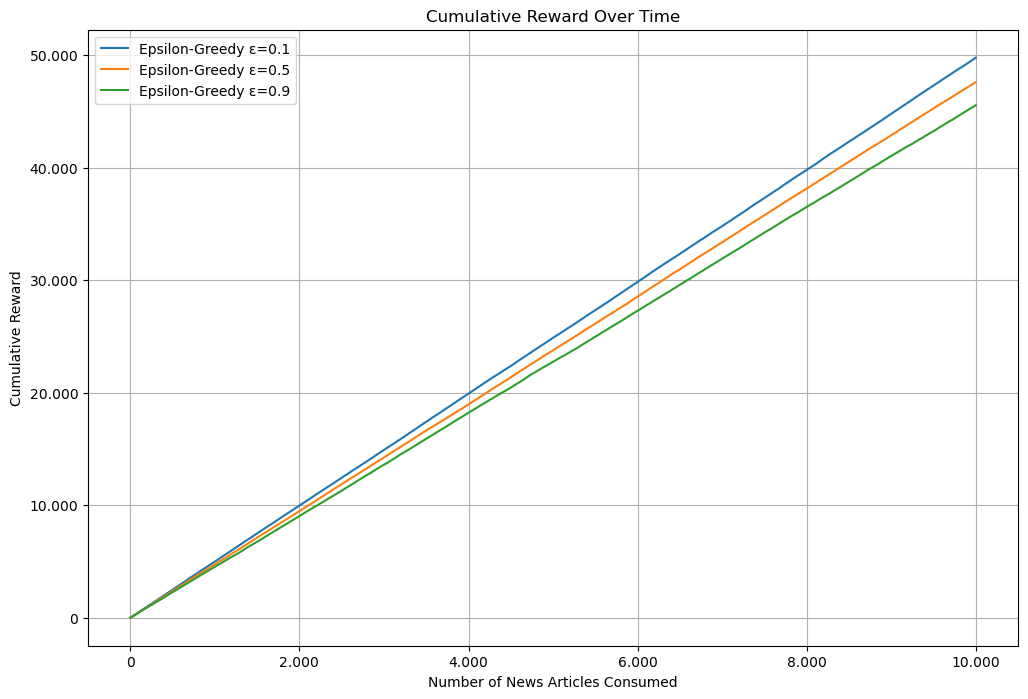

In [33]:
# Run replay
cum_rewards_eg_01, pull_eg_bandit_01 = eg_bandit_01.run_replay(arms_data, max_arm_pull, verbose=False)
print(eg_bandit_01)
cum_rewards_eg_05, pull_eg_bandit_05 = eg_bandit_05.run_replay(arms_data, max_arm_pull,verbose=False)
print(eg_bandit_05)
cum_rewards_eg_09, pull_eg_bandit_05 =  eg_bandit_09.run_replay(arms_data, max_arm_pull, verbose=False) 
print(eg_bandit_09)
# Plot the results
plot_results([cum_rewards_eg_01, cum_rewards_eg_05, cum_rewards_eg_09], 
             ['Epsilon-Greedy ε=0.1', 'Epsilon-Greedy ε=0.5', 'Epsilon-Greedy ε=0.9'])